# An Introduction to JAX

# GPU

This lecture was built using a machine with JAX installed and access to a GPU.

To run this lecture on [Google Colab](https://colab.research.google.com/), click on the “play” icon top right, select Colab, and set the runtime environment to include a GPU.

To run this lecture on your own machine, you need to install [Google JAX](https://github.com/google/jax).

This lecture provides a short introduction to [Google JAX](https://github.com/google/jax).

Let’s see if we have an active GPU:

In [3]:
!nvidia-smi

Mon Mar  3 12:21:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## JAX as a NumPy Replacement

One way to use JAX is as a plug-in NumPy replacement. Let’s look at the
similarities and differences.

### Similarities

The following import is standard, replacing `import numpy as np`:

In [4]:
import jax
import jax.numpy as jnp

Now we can use `jnp` in place of `np` for the usual array operations:

In [ ]:
a = jnp.asarray((1.0, 3.2, -1.5))

In [ ]:
print(a)

In [ ]:
print(jnp.sum(a))

In [ ]:
print(jnp.mean(a))

In [ ]:
print(jnp.dot(a, a))

However, the array object `a` is not a NumPy array:

In [ ]:
a

In [ ]:
type(a)

Even scalar-valued maps on arrays return JAX arrays.

In [ ]:
jnp.sum(a)

JAX arrays are also called “device arrays,” where term “device” refers to a
hardware accelerator (GPU or TPU).

(In the terminology of GPUs, the “host” is the machine that launches GPU operations, while the “device” is the GPU itself.)

Operations on higher dimensional arrays are also similar to NumPy:

In [ ]:
A = jnp.ones((2, 2))
B = jnp.identity(2)
A @ B

In [ ]:
from jax.numpy import linalg

In [ ]:
linalg.inv(B)   # Inverse of identity is identity

In [ ]:
linalg.eigh(B)  # Computes eigenvalues and eigenvectors

### Differences

One difference between NumPy and JAX is that JAX currently uses 32 bit floats by default.

This is standard for GPU computing and can lead to significant speed gains with small loss of precision.

However, for some calculations precision matters.  In these cases 64 bit floats can be enforced via the command

In [ ]:
jax.config.update("jax_enable_x64", True)

Let’s check this works:

In [ ]:
jnp.ones(3)

As a NumPy replacement, a more significant difference is that arrays are treated as **immutable**.

For example, with NumPy we can write

In [17]:
import numpy as np
a = np.linspace(0, 1, 3)
a

array([0. , 0.5, 1. ])

and then mutate the data in memory:

In [ ]:
a[0] = 1
a

In JAX this fails:

In [ ]:
a = jnp.linspace(0, 1, 3)
a

In [ ]:
a[0] = 1

In line with immutability, JAX does not support inplace operations:

In [ ]:
a = np.array((2, 1))
a.sort()
a

In [ ]:
a = jnp.array((2, 1))
a_new = a.sort()
a, a_new

The designers of JAX chose to make arrays immutable because JAX uses a
functional programming style.  More on this below.

Note that, while mutation is discouraged, it is in fact possible with `at`, as in

In [ ]:
a = jnp.linspace(0, 1, 3)
id(a)

In [ ]:
a

In [ ]:
a.at[0].set(1)

We can check that the array is mutated by verifying its identity is unchanged:

In [ ]:
id(a)

## Random Numbers

Random numbers are also a bit different in JAX, relative to NumPy.  Typically, in JAX, the state of the random number generator needs to be controlled explicitly.

In [ ]:
import jax.random as random

First we produce a key, which seeds the random number generator.

In [ ]:
key = random.PRNGKey(1)

In [ ]:
type(key)

In [ ]:
print(key)

Now we can use the key to generate some random numbers:

In [ ]:
x = random.normal(key, (3, 3))
x

If we use the same key again, we initialize at the same seed, so the random numbers are the same:

In [ ]:
random.normal(key, (3, 3))

To produce a (quasi-) independent draw, best practice is to “split” the existing key:

In [ ]:
key, subkey = random.split(key)

In [ ]:
random.normal(key, (3, 3))

In [ ]:
random.normal(subkey, (3, 3))

The function below produces `k` (quasi-) independent random `n x n` matrices using this procedure.

In [ ]:
def gen_random_matrices(key, n, k):
    matrices = []
    for _ in range(k):
        key, subkey = random.split(key)
        matrices.append(random.uniform(subkey, (n, n)))
    return matrices

In [ ]:
matrices = gen_random_matrices(key, 2, 2)
for A in matrices:
    print(A)

One point to remember is that JAX expects tuples to describe array shapes, even for flat arrays.  Hence, to get a one-dimensional array of normal random draws we use `(len, )` for the shape, as in

In [ ]:
random.normal(key, (5, ))

## JIT compilation

The JAX just-in-time (JIT) compiler accelerates logic within functions by fusing linear
algebra operations into a single optimized kernel that the host can
launch on the GPU / TPU (or CPU if no accelerator is detected).

### A first example

To see the JIT compiler in action, consider the following function.

In [3]:
def f(x):
    a = 3*x + jnp.sin(x) + jnp.cos(x**2) - jnp.cos(2*x) - x**2 * 0.4 * x**1.5
    return jnp.sum(a)

Let’s build an array to call the function on.

In [4]:
n = 50_000_000
x = jnp.ones(n)

How long does the function take to execute?

In [5]:
%time f(x).block_until_ready()

CPU times: user 223 ms, sys: 10.5 ms, total: 234 ms
Wall time: 418 ms


Array(2.198959e+08, dtype=float32)

>**Note**
>
>Here, in order to measure actual speed, we use the `block_until_ready()` method
to hold the interpreter until the results of the computation are returned from
the device. This is necessary because JAX uses asynchronous dispatch, which
allows the Python interpreter to run ahead of GPU computations.

The code doesn’t run as fast as we might hope, given that it’s running on a GPU.

But if we run it a second time it becomes much faster:

In [6]:
%time f(x).block_until_ready()

CPU times: user 3.86 ms, sys: 961 µs, total: 4.83 ms
Wall time: 28.9 ms


Array(2.198959e+08, dtype=float32)

异步计算：
JAX 默认使用 异步计算，即 Python 解释器可以在 GPU 计算还未完成时继续执行下一步代码。
block_until_ready() 使 Python 解释器等待 GPU 计算完全结束，然后测量时间，否则测量结果会不准确。


This is because the built in functions like `jnp.cos` are JIT compiled and the
first run includes compile time.

Why would JAX want to JIT-compile built in functions like `jnp.cos` instead of
just providing pre-compiled versions, like NumPy?

The reason is that the JIT compiler can specialize on the *size* of the array
being used, which is helpful for parallelization.

For example, in running the code above, the JIT compiler produced a version of `jnp.cos` that is
specialized to floating point arrays of size `n = 50_000_000`.

We can check this by calling `f` with a new array of different size.

In [7]:
m = 50_000_001
y = jnp.ones(m)

In [8]:
%time f(y).block_until_ready()

CPU times: user 199 ms, sys: 17.8 ms, total: 216 ms
Wall time: 363 ms


Array(2.1989597e+08, dtype=float32)

Notice that the execution time increases, because now new versions of
the built-ins like `jnp.cos` are being compiled, specialized to the new array
size.

If we run again, the code is dispatched to the correct compiled version and we
get faster execution.

In [9]:
%time f(y).block_until_ready()

CPU times: user 4.78 ms, sys: 198 µs, total: 4.97 ms
Wall time: 29.2 ms


Array(2.1989597e+08, dtype=float32)

The compiled versions for the previous array size are still available in memory
too, and the following call is dispatched to the correct compiled code.

In [10]:
%time f(x).block_until_ready()

CPU times: user 3.96 ms, sys: 984 µs, total: 4.95 ms
Wall time: 28.9 ms


Array(2.198959e+08, dtype=float32)

### Compiling the outer function

We can do even better if we manually JIT-compile the outer function.

In [11]:
f_jit = jax.jit(f)   # target for JIT compilation

这里 jax.jit(f) 会将函数 f 进行 JIT 编译，并返回一个新的函数 f_jit。
f_jit 现在是一个 JIT 加速的版本，执行时会比普通的 f(x) 运行得更快。

Let’s run once to compile it:

In [12]:
f_jit(x)

Array(2.198959e+08, dtype=float32)

第一次调用 f_jit(x) 时，JAX 会编译函数 f 并缓存优化结果。
后续调用 只会运行编译后的代码，而不会再次编译，速度大幅提升。

And now let’s time it.

In [13]:
%time f_jit(x).block_until_ready()

CPU times: user 629 µs, sys: 680 µs, total: 1.31 ms
Wall time: 7.35 ms


Array(2.198959e+08, dtype=float32)

Note the speed gain.

This is because the array operations are fused and no intermediate arrays are created.

Incidentally, a more common syntax when targetting a function for the JIT
compiler is

In [2]:
@jax.jit
def f(x):
    a = 3*x + jnp.sin(x) + jnp.cos(x**2) - jnp.cos(2*x) - x**2 * 0.4 * x**1.5
    return jnp.sum(a)

NameError: name 'jax' is not defined

## Functional Programming

From JAX’s documentation:

*When walking about the countryside of Italy, the people will not hesitate to tell you that JAX has “una anima di pura programmazione funzionale”.*

In other words, JAX assumes a functional programming style.

The major implication is that JAX functions should be pure.

A pure function will always return the same result if invoked with the same inputs.

In particular, a pure function has

- no dependence on global variables and  
- no side effects  


JAX will not usually throw errors when compiling impure functions but execution becomes unpredictable.

Here’s an illustration of this fact, using global variables:

In [5]:
a = 1  # global

@jax.jit
def f(x):
    return a + x

In [6]:
x = jnp.ones(2)

In [7]:
f(x)

Array([2., 2.], dtype=float32)

In the code above, the global value `a=1` is fused into the jitted function.

Even if we change `a`, the output of `f` will not be affected — as long as the same compiled version is called.

In [8]:
a = 42

In [9]:
f(x)

Array([2., 2.], dtype=float32)

Changing the dimension of the input triggers a fresh compilation of the function, at which time the change in the value of `a` takes effect:

In [10]:
x = jnp.ones(3)

In [11]:
f(x)

Array([43., 43., 43.], dtype=float32)

Moral of the story: write pure functions when using JAX!

## Gradients

JAX can use automatic differentiation to compute gradients.

This can be extremely useful for optimization and solving nonlinear systems.

We will see significant applications later in this lecture series.

For now, here’s a very simple illustration involving the function

In [12]:
def f(x):
    return (x**2) / 2

Let’s take the derivative:

In [13]:
f_prime = jax.grad(f)

In [14]:
f_prime(10.0)

Array(10., dtype=float32, weak_type=True)

Let’s plot the function and derivative, noting that $ f'(x) = x $.

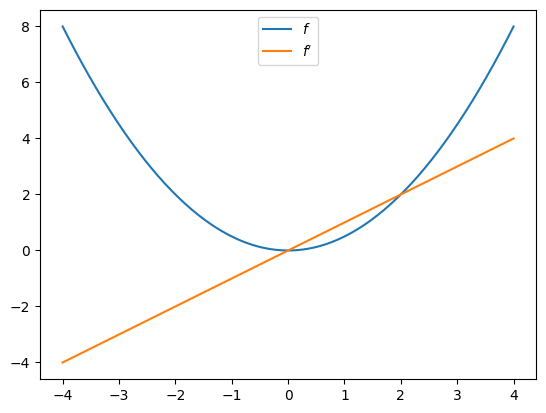

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
x_grid = jnp.linspace(-4, 4, 200)
ax.plot(x_grid, f(x_grid), label="$f$")
ax.plot(x_grid, [f_prime(x) for x in x_grid], label="$f'$")
ax.legend(loc='upper center')
plt.show()

We defer further exploration of automatic differentiation with JAX until [Adventures with Autodiff](https://jax.quantecon.org/autodiff.html).

## Writing vectorized code

Writing fast JAX code requires shifting repetitive tasks from loops to array processing operations, so that the JAX compiler can easily understand the whole operation and generate more efficient machine code.

This procedure is called **vectorization** or **array programming**, and will be familiar to anyone who has used NumPy or MATLAB.

In most ways, vectorization is the same in JAX as it is in NumPy.

But there are also some differences, which we highlight here.

As a running example, consider the function

$$
f(x,y) = \frac{\cos(x^2 + y^2)}{1 + x^2 + y^2}
$$

Suppose that we want to evaluate this function on a square grid of $ x $ and $ y $ points and then plot it.

To clarify, here is the slow `for` loop version.

In [18]:
@jax.jit
def f(x, y):
    return jnp.cos(x**2 + y**2) / (1 + x**2 + y**2)

n = 80
x = jnp.linspace(-2, 2, n)
y = x

z_loops = np.empty((n, n))

In [19]:
%%time
for i in range(n):
    for j in range(n):
        z_loops[i, j] = f(x[i], y[j])

CPU times: user 7.7 s, sys: 2.18 s, total: 9.88 s
Wall time: 7.93 s


这段代码使用 双重 for 循环 计算 f(x, y)，每次计算 单个数值对 (x[i], y[j])。
计算量 = 80 × 80 = 6400 次函数调用，即便 f 被 JIT 编译，仍然很慢。

Even for this very small grid, the run time is extremely slow.

(Notice that we used a NumPy array for `z_loops` because we wanted to write to it.)

OK, so how can we do the same operation in vectorized form?

If you are new to vectorization, you might guess that we can simply write

In [20]:
z_bad = f(x, y)

But this gives us the wrong result because JAX doesn’t understand the nested for loop.

In [21]:
z_bad.shape

(80,)

Here is what we actually wanted:

In [22]:
z_loops.shape

(80, 80)

To get the right shape and the correct nested for loop calculation, we can use a `meshgrid` operation designed for this purpose:

In [23]:
x_mesh, y_mesh = jnp.meshgrid(x, y)

mesh 在英文中的意思是 网格，在编程中，它通常表示 规则排列的点（坐标网格），用于计算二维或三维空间中的函数值。

jnp.meshgrid(x, y) 创建二维网格：
x_mesh 是 x 复制到 80×80 维数组的行方向版本。
y_mesh 是 y 复制到 80×80 维数组的列方向版本。
这样 x_mesh[i, j] 和 y_mesh[i, j] 代表了二维网格上的所有 (x, y) 组合。

Now we get what we want and the execution time is very fast.

In [24]:
%%time
z_mesh = f(x_mesh, y_mesh).block_until_ready()

CPU times: user 43.3 ms, sys: 1.22 ms, total: 44.6 ms
Wall time: 64.9 ms


Let’s run again to eliminate compile time.

In [25]:
%%time
z_mesh = f(x_mesh, y_mesh).block_until_ready()

CPU times: user 905 µs, sys: 0 ns, total: 905 µs
Wall time: 588 µs


Let’s confirm that we got the right answer.

In [26]:
jnp.allclose(z_mesh, z_loops)

Array(True, dtype=bool)

Now we can set up a serious grid and run the same calculation (on the larger grid) in a short amount of time.

In [27]:
n = 6000
x = jnp.linspace(-2, 2, n)
y = x
x_mesh, y_mesh = jnp.meshgrid(x, y)

In [28]:
%%time
z_mesh = f(x_mesh, y_mesh).block_until_ready()

CPU times: user 42.2 ms, sys: 881 µs, total: 43 ms
Wall time: 43.1 ms


 Wall Time（墙上时间）
Wall Time（挂钟时间）指的是从代码开始执行到结束所经历的真实时间，包括：
代码运行的时间
等待时间（比如 I/O 操作、网络请求、数据传输）
并行计算（如果计算在多个 CPU/GPU 核心上并行运行）

 CPU Time（CPU 计算时间）
CPU Time 是 CPU 真实执行计算所花费的时间，不包括等待时间或并行计算带来的优化。
在 多线程 或 GPU 加速 的情况下，CPU Time 可能小于 Wall Time，因为计算可能分配到多个核心或 GPU 进行并行处理。

Let’s run again to get rid of compile time.

In [29]:
%%time
z_mesh = f(x_mesh, y_mesh).block_until_ready()

CPU times: user 487 µs, sys: 754 µs, total: 1.24 ms
Wall time: 2.06 ms


But there is one problem here: the mesh grids use a lot of memory.

In [30]:
x_mesh.nbytes + y_mesh.nbytes

288000000

meshgrid 生成 两个 6000×6000 的矩阵：

x_mesh.shape = (6000, 6000)

y_mesh.shape = (6000, 6000)

假设数据类型为 float32（每个数占 4 字节）：

6000 × 6000 × 4 bytes = 144,000,000 bytes（144MB）

x_mesh + y_mesh = 144MB + 144MB = 288MB

By comparison, the flat array `x` is just

In [31]:
x.nbytes  # and y is just a pointer to x

24000

This extra memory usage can be a big problem in actual research calculations.

So let’s try a different approach using [jax.vmap](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html)

First we vectorize `f` in `y`.

In [33]:
f_vec_y = jax.vmap(f, in_axes=(None, 0))

jax.vmap() 自动向量化函数 f，避免使用 for 循环。

in_axes=(None, 0) 的意思：

None → x 保持不变（作为标量）。
0 → y 变成一个向量（遍历 y 数组）。

效果：现在 f_vec_y(x, y) 可以一次性计算所有 y 值，而 x 仍然是一个单个数。

In the line above, `(None, 0)` indicates that we are vectorizing in the second argument, which is `y`.

Next, we vectorize in the first argument, which is `x`.

In [34]:
f_vec = jax.vmap(f_vec_y, in_axes=(0, None))

With this construction, we can now call the function $ f $ on flat (low memory) arrays.

In [35]:
%%time
z_vmap = f_vec(x, y).block_until_ready()

CPU times: user 44.5 ms, sys: 1.84 ms, total: 46.3 ms
Wall time: 66.9 ms


We run it again to eliminate compile time.

In [36]:
%%time
z_vmap = f_vec(x, y).block_until_ready()

CPU times: user 2.03 ms, sys: 0 ns, total: 2.03 ms
Wall time: 2.88 ms


The execution time is essentially the same as the mesh operation but we are using much less memory.

And we produce the correct answer:

In [37]:
jnp.allclose(z_vmap, z_mesh)

Array(True, dtype=bool)

z_mesh 是 meshgrid 方法计算的结果。
z_vmap 是 vmap

jnp.allclose() 检查两者是否几乎相等（允许小误差）。
如果返回 True，说明 jax.vmap() 计算的结果与 meshgrid 一致。

## Exercises

## Exercise 2.1

In the Exercise section of [a lecture on Numba and parallelization](https://python-programming.quantecon.org/parallelization.html), we used Monte Carlo to price a European call option.

The code was accelerated by Numba-based multithreading.

Try writing a version of this operation for JAX, using all the same
parameters.

If you are running your code on a GPU, you should be able to achieve
significantly faster execution.

## **欧式看涨期权（European Call Option）定价原理**

你可以把 **期权（Option）** 理解为一种 **金融合约**，它赋予持有者在 **未来特定时间** 以 **固定价格** 购买某资产的权利（但不是义务）。

---

## **1. 欧式看涨期权的基本规则**

- 持有者在**到期日 \(T\)** 时，**有权以固定价格 \(K\) 购买** 标的资产（如股票）。
- **收益取决于** 到期时 **资产价格 \( S_T \)** 和 **执行价 \( K \)** 的对比：
  - **如果 \( S_T > K \)**：买方可以低价买入股票，然后立即在市场上卖出，获得 **收益 \( S_T - K \)**。
  - **如果 \( S_T \leq K \)**：买方不会行权，期权变为 **零价值**。
  
因此，**期权的价值（到期日的支付）是**：

\[
\max(S_T - K, 0)
\]

例如：
- \( S_T = 120, K = 100 \) → 期权价值 \( 120 - 100 = 20 \)
- \( S_T = 90, K = 100 \) → 期权价值 \( 0 \)（因买入价高于市场价）

---

## **2. 期权的定价公式**

我们需要知道这个期权 **今天** 的价值 \( V_0 \)，但问题是：
1. **未来的资产价格 \( S_T \) 是不确定的**，因为股票价格是随机变化的。
2. **期权的价值是未来的不确定收益，我们需要计算它的“合理”价格。**

根据金融定价理论：

$$
P = \beta^n \mathbb E \max\{ S_n - K, 0 \}
$$

其中：
- \( \mathbb{E}[\cdot] \) 表示对 **未来资产价格 \( S_T \) 进行期望计算**（即考虑各种可能的市场情况）。
- \( \beta^n \) 是 **折现因子**，因为未来的钱比今天的价值低（比如 1 年后的 100 块钱 < 今天的 100 块钱）。
- 这个期望 \( \mathbb{E}[\max(S_T - K, 0)] \) **是核心**，我们要计算它的值。

---

## **3. 为什么可以用蒙特卡洛方法？**

现实中，股票价格的变化是随机的，我们无法准确预测 **未来的 \( S_T \)**，所以 **用蒙特卡洛模拟大量可能的未来价格**，然后计算它们的平均值！

具体步骤：

1. **用数学模型模拟资产价格**：
   - 设定初始价格 \( S_0 \)。
   - 让价格 **随机变化**，模拟 **n=20** 天后的价格 \( S_T \)。
   - 进行 **1000 万次模拟**，得到 **1000 万个不同的 \( S_T \)**。

2. **计算每次模拟的期权收益**：
   - 如果 \( S_T > K \)，收益是 \( S_T - K \)。
   - 如果 \( S_T \leq K \)，收益是 0。

3. **求所有模拟的期望值**：
   - 计算所有收益的 **平均值**。
   - **折现回今天的价值**（因为未来的钱要打折）。
$$
V_0 = \beta^n \times \frac{1}{M} \sum_{i=1}^{M} \max(S_{T,i} - K, 0)
$$

---

## **4. 代码如何实现？**

### **(1) 资产价格的模拟**
```python
s = np.log(S0)  # 取对数价格
h = h0  # 初始波动率

# 逐步模拟价格路径
for t in range(n):
    s = s + μ + np.exp(h) * randn()
    h = ρ * h + ν * randn()
```
这部分代码模拟 **从 \( S_0 \) 变化到 \( S_T \)** 的 20 个时间步：
- `randn()` 生成正态分布随机数，让价格 **随机波动**。
- `exp(h) * randn()` 让价格变化幅度 **受波动率 h 影响**（类似市场的波动性）。
- `ρ * h + ν * randn()` 让波动率 `h` 也发生随机变化（符合现实市场）。

最终，我们得到了 **某次模拟下的 \( S_T \)**。

---

### **(2) 计算期权价值**
```python
current_sum += np.maximum(np.exp(s) - K, 0)
```
- **计算 \( S_T = e^s \)**（对数变换回原值）。
- **计算看涨期权的收益**：如果 \( S_T > K \)，收益是 \( S_T - K \)；否则是 0。

---

### **(3) 计算期权的理论价格**
```python
return β**n * current_sum / M
```
- **求所有模拟结果的平均值**（相当于 \( \mathbb{E}[\max(S_T - K, 0)] \)）。
- **乘以折现因子 \( \beta^n \)**，得到今天的价格 \( V_0 \)。

---

## **5. 为什么并行计算可以加速？**

- 每条模拟路径 **是完全独立的**，它们之间没有任何关联。
- `prange(M)` 让 CPU 并行计算多个路径，比如 4 核 CPU 可以 **并行计算 4 组路径**，减少计算时间。

---

## **6. 关键总结**
 **蒙特卡洛方法** 通过模拟 **大量未来可能的资产价格**，然后计算期权收益的期望值。
**资产价格是随机的**，所以不能用确定性方法，而是用随机模拟。
**并行计算加速**：
   - 每条路径**独立计算**，适合 `prange` 并行处理。
   - `@njit(parallel=True)` 让 `Numba` 自动分配多个 CPU 线程，提高计算速度。
**现实应用**：
   - 这种方法用于 **计算衍生品定价**，比如股票期权、外汇期权等。
   - 适用于 **市场模拟、风险管理、资产配置** 等金融工程应用。



## Solution to[ Exercise 2.1](https://jax.quantecon.org/#jax_intro_ex2)

Here is one solution:

In [38]:
M = 10_000_000

n, β, K = 20, 0.99, 100
μ, ρ, ν, S0, h0 = 0.0001, 0.1, 0.001, 10, 0

@jax.jit
def compute_call_price_jax(β=β,
                           μ=μ,
                           S0=S0,
                           h0=h0,
                           K=K,
                           n=n,
                           ρ=ρ,
                           ν=ν,
                           M=M,
                           key=jax.random.PRNGKey(1)):

    s = jnp.full(M, np.log(S0))
    h = jnp.full(M, h0)
    for t in range(n):
        key, subkey = jax.random.split(key)
        Z = jax.random.normal(subkey, (2, M))
        s = s + μ + jnp.exp(h) * Z[0, :]
        h = ρ * h + ν * Z[1, :]
    expectation = jnp.mean(jnp.maximum(jnp.exp(s) - K, 0))

    return β**n * expectation

s = jnp.full(M, np.log(S0))：
s 是 对数价格路径（用 log(S0) 作为起始值）。
M=10_000_000，表示同时模拟 1000 万条价格路径。

h = jnp.full(M, h0)：
h 是 波动率路径（从 h0=0 开始）。

这个 for 循环 模拟了 n=20 天后的资产价格。

jax.random.split(key) 生成新的随机种子，保证每次模拟的随机性。

Z = jax.random.normal(subkey, (2, M))：
生成两个标准正态分布的随机变量：

- Z[0, :] 影响价格st

- Z[1, :] 影响波动率ht

Let’s run it once to compile it:

In [ ]:
%%time
compute_call_price_jax().block_until_ready()

And now let’s time it:

In [ ]:
%%time
compute_call_price_jax().block_until_ready()

In [ ]:
原本不用jax的代码：
from numpy.random import randn
M = 10_000_000

n, β, K = 20, 0.99, 100
μ, ρ, ν, S0, h0 = 0.0001, 0.1, 0.001, 10, 0

@njit(parallel=True)
def compute_call_price_parallel(β=β,
                                μ=μ,
                                S0=S0,
                                h0=h0,
                                K=K,
                                n=n,
                                ρ=ρ,
                                ν=ν,
                                M=M):
    current_sum = 0.0
    # For each sample path
    for m in prange(M):
        s = np.log(S0)
        h = h0
        # Simulate forward in time
        for t in range(n):
            s = s + μ + np.exp(h) * randn()
            h = ρ * h + ν * randn()
        # And add the value max{S_n - K, 0} to current_sum
        current_sum += np.maximum(np.exp(s) - K, 0)

    return β**n * current_sum / M

# **JAX vs Numba：蒙特卡洛期权定价的实现对比**

这两段代码都用于 **蒙特卡洛方法（Monte Carlo Method）** 计算 **欧式看涨期权（European Call Option）的价格**，但它们采用了 **不同的并行计算方法**，分别是 **JAX（支持 GPU/TPU 加速）** 和 **Numba（支持 CPU 多线程并行）**。

---

## **1. 主要区别**
| **特性** | **JAX 版本** | **Numba 版本** |
|----------|-------------|--------------|
| **并行计算方式** | 使用 **JAX** 和 **XLA** 进行 **GPU/TPU 加速** | 使用 **Numba（@njit(parallel=True)）** 进行 **CPU 多线程计算** |
| **随机数生成** | `jax.random` 生成伪随机数，确保并行计算的一致性 | `numpy.random.randn()` 生成标准正态分布随机数 |
| **循环结构** | `for` 循环仍然存在，但依赖 `jax.jit` 进行优化 | `prange()` 让 NumPy 代码 **在 CPU 上并行执行** |
| **自动求导** | JAX 可以用于 **梯度计算**，如果需要 | Numba 不支持自动求导 |
| **矩阵运算** | `jnp`（JAX 数组）可以利用 GPU/TPU | `numpy`（NumPy 数组）只能使用 CPU |

---

## **2. 代码解析**
### **(1) 期权定价公式**
欧式看涨期权的价值由以下公式计算：

$$
C = e^{-\beta n} \mathbb{E} \left[ \max(S_n - K, 0) \right]
$$

其中：
- \( \beta \) 是贴现因子
- \( n \) 是期权到期时间
- \( K \) 是行权价
- \( S_n \) 是到期时的资产价格
- \( \mathbb{E} \) 代表期望

在 JAX 和 Numba 版本中，我们都使用 **蒙特卡洛模拟** 来估计这个期望值。

---

### **(2) 资产价格模拟**
资产价格的随机过程为：

$$
s_{t+1} = s_t + \mu + e^{h_t} Z_{t,1}
$$

$$
h_{t+1} = \rho h_t + \nu Z_{t,2}
$$

其中：
- \( s_t = \log S_t \) 是资产对数价格
- \( h_t \) 是波动率因子
- \( Z_{t,1}, Z_{t,2} \sim N(0,1) \) 是标准正态分布的随机数
- \( \mu, \rho, \nu \) 是模型参数

